# Bayesian Anomaly Detection - Example

This is a simple script showing how to integrate a likelihood capable of correcting for anomalies into a Bayesian data analysis pipeline.

## Generate Mock Data

First, generate some mock data.

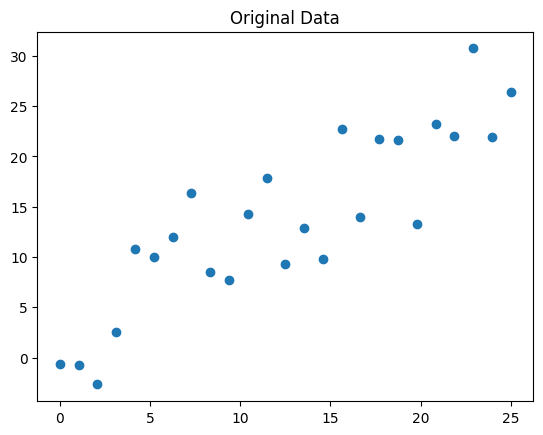

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 25
x = np.linspace(0, 25, N)
m = 1
c = 1
sig = 5
y = m * x + c + np.random.randn(N) * sig
plt.plot(x, y, "o")
plt.title("Original Data")
plt.show()

## Add Anomalies

Add some anomalies to the data

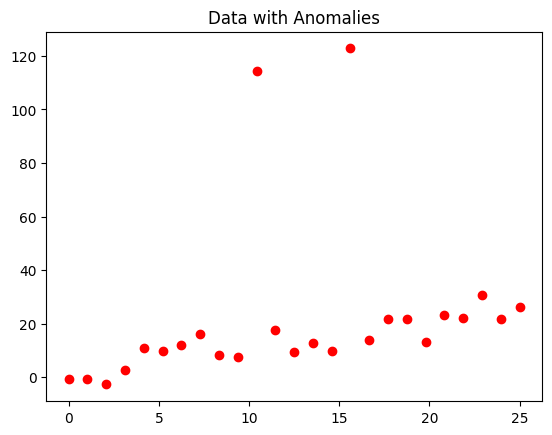

In [2]:
y[10] += 100
y[15] += 100
plt.plot(x, y, "ro")
plt.title("Data with Anomalies")
plt.show()

## Define Likelihood Functions

Now, define a traditional likelihood function and fit the data without modeling the anomalies.

In [3]:
def likelihood(theta):
    m = theta[0]
    c = theta[1]
    sig = theta[2]
    y_ = m * x + c
    return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()

Now, we'll define a likelihood function that can correct for anomalies.
Note the difference between the two likelihoods. Notice the condition imposed on the likelihood by `emax'.

In [4]:
def anomaly_corrected_likelihood(theta):
    m = theta[0]
    c = theta[1]
    sig = theta[2]
    logp = theta[3]  # logp is now a free parameter
    p = np.exp(logp)
    y_ = m * x + c
    logL = (
        -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)
    )
    emax = logL > logp - np.log(delta)
    logPmax = np.where(emax, logL, logp - np.log(delta)).sum()
    return logPmax

## Define Prior and Parameters

Define a prior. Notice that the prior range which encapsulates the full range of possible values from the data as defined by delta.

In [5]:
def uniform_prior(a, b):
    """Simple uniform prior function"""
    def prior_func(u):
        return a + (b - a) * u
    return prior_func

def prior(hypercube):
    theta = np.zeros_like(hypercube)
    theta[0] = uniform_prior(
        -delta / (np.max(x) - np.min(x)), delta / (np.max(x) - np.min(x))
    )(hypercube[1])  # m
    theta[1] = uniform_prior(-delta, delta)(hypercube[0])  # c
    theta[2] = uniform_prior(0, delta)(hypercube[2])  # sig
    theta[3] = uniform_prior(-10, -0.1)(hypercube[3])  # logp with prior from -10 to -0.1
    return theta

Set $p$ (the probability thresholding term) and $\Delta$ (the length scale in units of data)

In [6]:
delta = np.max(y)
# logp will now be a free parameter sampled from the prior

## Fit model with basic sampler

Implement a basic Metropolis-Hastings MCMC sampler that doesn't require any external packages. We use basic MCMC for the demonstration, but note that any numerical sampling procedure would work here. We reccomend GPU optimised Nested Sampling [https://handley-lab.co.uk/nested-sampling-book/intro.html] for more complex problems.

In [7]:
def simple_mcmc(log_likelihood, prior_func, n_samples=10000, n_burn=1000, step_size=0.1):
    """
    Simple Metropolis-Hastings MCMC sampler
    
    Parameters:
    -----------
    log_likelihood : function
        Function that takes parameters and returns log likelihood
    prior_func : function
        Function that transforms from unit hypercube to parameter space
    n_samples : int
        Number of samples to draw
    n_burn : int
        Number of burn-in samples
    step_size : float
        Step size for proposal distribution
    
    Returns:
    --------
    samples : array
        MCMC samples
    """
    # Initialize - now 4 dimensions to include logp
    n_dims = 4
    samples = np.zeros((n_samples, n_dims))
    
    # Start from center of unit hypercube
    current_hypercube = np.array([0.5, 0.5, 0.5, 0.5])
    current_params = prior_func(current_hypercube)
    current_logL = log_likelihood(current_params)
    
    n_accepted = 0
    
    for i in range(n_samples + n_burn):
        # Propose new state
        proposal_hypercube = current_hypercube + np.random.normal(0, step_size, n_dims)
        
        # Reflect at boundaries to stay in [0,1]
        proposal_hypercube = np.clip(proposal_hypercube, 0, 1)
        
        proposal_params = prior_func(proposal_hypercube)
        proposal_logL = log_likelihood(proposal_params)
        
        # Accept/reject
        log_alpha = proposal_logL - current_logL
        if np.log(np.random.rand()) < log_alpha:
            current_hypercube = proposal_hypercube
            current_params = proposal_params
            current_logL = proposal_logL
            n_accepted += 1
        
        # Store sample after burn-in
        if i >= n_burn:
            samples[i - n_burn] = current_params
    
    acceptance_rate = n_accepted / (n_samples + n_burn)
    print(f"Acceptance rate: {acceptance_rate:.3f}")
    
    return samples

## Fit with Traditional Likelihood

We first fit the data using the traditional likelihood

In [8]:
print("Fitting with traditional likelihood...")
samples_no_correction = simple_mcmc(likelihood, prior, n_samples=5000)

Fitting with traditional likelihood...
Acceptance rate: 0.107


/tmp/ipykernel_311960/3102404388.py:6: RuntimeWarning: divide by zero encountered in divide
  return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()
/tmp/ipykernel_311960/3102404388.py:6: RuntimeWarning: divide by zero encountered in log
  return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()
/tmp/ipykernel_311960/3102404388.py:6: RuntimeWarning: invalid value encountered in subtract
  return (-((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2).sum()


## Fit with Anomaly-Corrected Likelihood

Fit the data, this time using the correcting likelihood

In [9]:
print("Fitting with anomaly-corrected likelihood...")
samples_corrected = simple_mcmc(anomaly_corrected_likelihood, prior, n_samples=5000)

Fitting with anomaly-corrected likelihood...


/tmp/ipykernel_311960/2134811479.py:9: RuntimeWarning: divide by zero encountered in divide
  -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)
/tmp/ipykernel_311960/2134811479.py:9: RuntimeWarning: divide by zero encountered in log
  -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)
/tmp/ipykernel_311960/2134811479.py:9: RuntimeWarning: invalid value encountered in subtract
  -((y_ - y) ** 2) / sig**2 / 2 - np.log(2 * np.pi * sig**2) / 2 + np.log(1 - p)


Acceptance rate: 0.006


## Compare Results

Plot and compare the results from both approaches

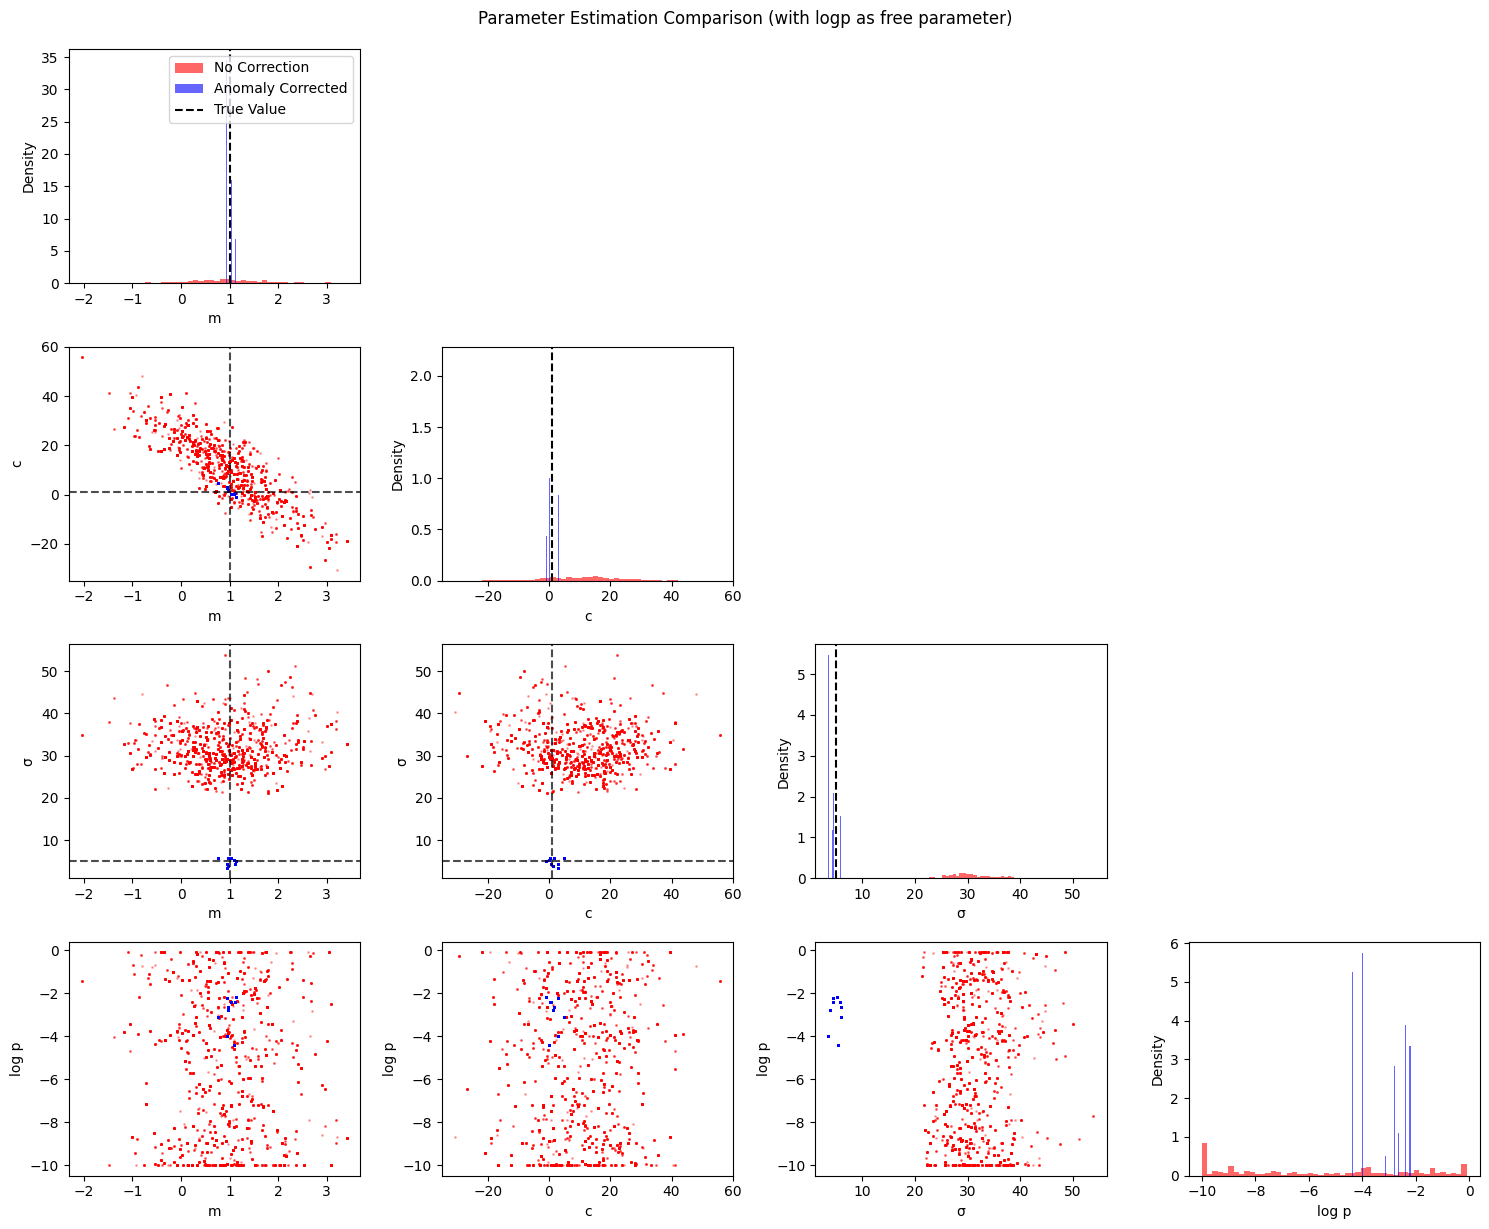

In [10]:
# Create corner plot
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
param_names = ['m', 'c', 'σ', 'log p']
true_values = [1, 1, 5, -2.5]  # True parameter values including logp

for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: 1D histograms
            ax.hist(samples_no_correction[:, i], bins=50, alpha=0.6, 
                   label='No Correction', density=True, color='red')
            ax.hist(samples_corrected[:, i], bins=50, alpha=0.6, 
                   label='Anomaly Corrected', density=True, color='blue')
            if i < 3:  # Only show true value line for m, c, σ (not for logp since it wasn't fixed before)
                ax.axvline(true_values[i], color='black', linestyle='--', label='True Value')
            ax.set_xlabel(param_names[i])
            ax.set_ylabel('Density')
            if i == 0:
                ax.legend()
                
        elif i > j:
            # Lower triangle: 2D scatter plots
            ax.scatter(samples_no_correction[:, j], samples_no_correction[:, i], 
                      alpha=0.3, s=1, color='red', label='No Correction')
            ax.scatter(samples_corrected[:, j], samples_corrected[:, i], 
                      alpha=0.3, s=1, color='blue', label='Anomaly Corrected')
            if i < 3 and j < 3:  # Only show true value lines for original parameters
                ax.axhline(true_values[i], color='black', linestyle='--', alpha=0.7)
                ax.axvline(true_values[j], color='black', linestyle='--', alpha=0.7)
            ax.set_xlabel(param_names[j])
            ax.set_ylabel(param_names[i])
            
        else:
            # Upper triangle: remove
            ax.axis('off')

plt.tight_layout()
plt.suptitle('Parameter Estimation Comparison (with logp as free parameter)', y=1.02)
plt.show()

## Summary Statistics

Compare the parameter estimates quantitatively

In [11]:
print("Parameter Estimation Summary:")
print("=" * 60)
print(f"{'Parameter':<10} {'True':<8} {'No Corr':<15} {'Corrected':<15}")
print("-" * 60)

for i, (name, true_val) in enumerate(zip(param_names, true_values)):
    no_corr_mean = np.mean(samples_no_correction[:, i])
    no_corr_std = np.std(samples_no_correction[:, i])
    corr_mean = np.mean(samples_corrected[:, i])
    corr_std = np.std(samples_corrected[:, i])
    
    if i < 3:  # For original parameters, show comparison to true value
        print(f"{name:<10} {true_val:<8.1f} {no_corr_mean:<7.2f}±{no_corr_std:<6.2f} {corr_mean:<7.2f}±{corr_std:<6.2f}")
    else:  # For logp, don't show "true" value since it's now free
        print(f"{name:<10} {'free':<8} {no_corr_mean:<7.2f}±{no_corr_std:<6.2f} {corr_mean:<7.2f}±{corr_std:<6.2f}")

Parameter Estimation Summary:
Parameter  True     No Corr         Corrected      
------------------------------------------------------------
m          1.0      0.92   ±0.82   1.00   ±0.08  
c          1.0      10.29  ±12.39  1.42   ±1.40  
σ          5.0      30.97  ±4.74   4.65   ±0.86  
log p      free     -5.59  ±3.39   -3.31  ±0.88  


## Key Point

The vast majority of this example makes up the general 'pipeline' for simulating and analysing the data. Only three lines of code are modified (inside `anomaly_corrected_likelihood`) to implement the anomaly detection correction.

Notice that σ is estimated completely wrong in the uncorrected case, and the confidence in the other parameters is low. The anomaly detection approach provides much more accurate parameter estimates.